# SVM classification on the Ozone dataset
Author: Tomas Hobza

In [1]:
# SVM classification on the Ozone dataset
# Author: Tomas Hobza

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set random seed for reproducibility
np.random.seed(42)

## 0. Load the dataset

In [4]:
## 0. Load the dataset

# Load the parquet files
df = pd.read_parquet('ozone_cleaned.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['isOzoneDay'].value_counts())
print(f"\nClass balance ratio: {df['isOzoneDay'].value_counts().min() / df['isOzoneDay'].value_counts().max():.3f}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (2534, 73)

Class distribution:
isOzoneDay
0    2374
1     160
Name: count, dtype: int64

Class balance ratio: 0.067

First 5 rows:


,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,isOzoneDay
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,0
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,0
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,0
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,0
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,0



Missing values: 0


Split the dataset into training and testing.

In [5]:
# Split the data into features and labels
X = df.drop(columns=['isOzoneDay'])
y = df['isOzoneDay']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 2027 samples
Test set size: 507 samples

Training set class distribution:
isOzoneDay
0    1899
1     128
Name: count, dtype: int64

Test set class distribution:
isOzoneDay
0    475
1     32
Name: count, dtype: int64


Scale the data.

In [6]:
# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# ============= FEATURE SCALING =============
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Check feature scales before scaling
print("\nFeature statistics BEFORE scaling (training set):")
print(X_train.describe().loc[['mean', 'std', 'min', 'max']].round(3))

# Initialize and fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling from training

# Convert back to DataFrame to maintain feature names (optional, for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeature statistics AFTER scaling (training set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

print("\n✓ Features scaled using StandardScaler (zero mean, unit variance)")
print("✓ Scaler fitted on training set only, then applied to test set")
print("="*60)

Training set size: 2027 samples
Test set size: 507 samples

Training set class distribution:
isOzoneDay
0    1899
1     128
Name: count, dtype: int64

Test set class distribution:
isOzoneDay
0    475
1     32
Name: count, dtype: int64

FEATURE SCALING

Feature statistics BEFORE scaling (training set):
       WSR0   WSR1   WSR2   WSR3   WSR4   WSR5   WSR6  WSR7   WSR8   WSR9  \
mean  1.659  1.597  1.549  1.534  1.530  1.544  1.641  2.05  2.548  2.863   
std   1.204  1.199  1.170  1.141  1.136  1.103  1.098  1.10  1.128  1.152   
min   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00  0.100  0.100   
max   7.500  7.700  7.100  7.300  7.200  7.400  7.400  7.50  9.200  8.500   

      ...     T50   RH50     U50     V50      HT50      KI      TT        SLP  \
mean  ... -10.524  0.306   9.836   0.927  5818.152  10.418  37.368  10163.952   
std   ...   3.817  0.245   9.099   7.131    77.504  20.199  10.911     51.718   
min   ... -22.900  0.010 -14.920 -25.990  5480.000 -56.700 -10.100  

## 1. Experiment - holdout vs cross validatoion

In [7]:
## 1. Experiment - holdout vs cross-validation

print("\n" + "="*60)
print("HOLDOUT VS CROSS-VALIDATION COMPARISON")
print("="*60)
print("Primary metric: F1 Score (weighted)")
print("="*60)

# == HOLDOUT APPROACH ==
print("\n[1/2] Training with holdout validation...")
model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
start = time.time()
model.fit(X_train_scaled, y_train)
holdout_time = time.time() - start

y_pred = model.predict(X_test_scaled)
holdout_f1 = f1_score(y_test, y_pred, average='weighted')
holdout_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"  Holdout F1 Score:         {holdout_f1:.4f}")
print(f"  Holdout Balanced Accuracy: {holdout_bal_acc:.4f}")
print(f"  Training time:             {holdout_time:.3f}s")

# == CROSS-VALIDATION APPROACH ==
print("\n[2/2] Training with 5-fold cross-validation...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start = time.time()
# F1 Score (primary metric)
cv_scores_f1 = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='f1_macro',
    n_jobs=-1
)

# Balanced Accuracy (secondary metric)
cv_scores_bal_acc = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"  CV F1 Score per fold:         {[f'{s:.4f}' for s in cv_scores_f1]}")
print(f"  CV F1 Mean:                   {cv_scores_f1.mean():.4f}")
print(f"  CV F1 Std:                    ±{cv_scores_f1.std():.4f}")
print(f"\n  CV Balanced Accuracy per fold: {[f'{s:.4f}' for s in cv_scores_bal_acc]}")
print(f"  CV Balanced Accuracy Mean:    {cv_scores_bal_acc.mean():.4f}")
print(f"  CV Balanced Accuracy Std:     ±{cv_scores_bal_acc.std():.4f}")
print(f"\n  Training time:                {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")

# Comparison
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print("F1 Score (Primary Metric):")
print(f"  Holdout:          {holdout_f1:.4f}")
print(f"  CV Mean:          {cv_scores_f1.mean():.4f}")
print(f"  Difference:       {abs(holdout_f1 - cv_scores_f1.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_f1.std():.4f}")

print("\nBalanced Accuracy (Secondary Metric):")
print(f"  Holdout:          {holdout_bal_acc:.4f}")
print(f"  CV Mean:          {cv_scores_bal_acc.mean():.4f}")
print(f"  Difference:       {abs(holdout_bal_acc - cv_scores_bal_acc.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_bal_acc.std():.4f}")

print("\nComputational Cost:")
print(f"  Holdout time:     {holdout_time:.3f}s")
print(f"  CV time:          {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")
print("="*60)


HOLDOUT VS CROSS-VALIDATION COMPARISON
Primary metric: F1 Score (weighted)

[1/2] Training with holdout validation...
  Holdout F1 Score:         0.8804
  Holdout Balanced Accuracy: 0.8169
  Training time:             0.073s

[2/2] Training with 5-fold cross-validation...
  CV F1 Score per fold:         ['0.6404', '0.6555', '0.6490', '0.6401', '0.6659']
  CV F1 Mean:                   0.6502
  CV F1 Std:                    ±0.0098

  CV Balanced Accuracy per fold: ['0.7459', '0.8734', '0.8076', '0.7876', '0.8021']
  CV Balanced Accuracy Mean:    0.8033
  CV Balanced Accuracy Std:     ±0.0412

  Training time:                2.632s (35.8x longer)

COMPARISON SUMMARY
F1 Score (Primary Metric):
  Holdout:          0.8804
  CV Mean:          0.6502
  Difference:       0.2302
  CV Std Dev:       ±0.0098

Balanced Accuracy (Secondary Metric):
  Holdout:          0.8169
  CV Mean:          0.8033
  Difference:       0.0136
  CV Std Dev:       ±0.0412

Computational Cost:
  Holdout time:     

## 2. Experiment - C parameter

In [8]:
## 2. Experiment - C Parameter (using Cross-Validation on Training Set)

print("="*60)
print("HYPERPARAMETER TUNING: C PARAMETER")
print("="*60)
print("Using 5-fold cross-validation on TRAINING SET ONLY")
print("Using SCALED features\n")

# Test range of C values (regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_C = []

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Testing C parameter values with CV on training set...")
for C in C_values:
    print(f"\n  C = {C}")
    model = LinearSVC(C=C, class_weight='balanced', max_iter=2000, random_state=42)
    
    # Cross-validation on TRAINING set only (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='f1_weighted',  # Changed to f1_weighted for binary classification
        n_jobs=-1
    )
    cv_scores_precision = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='precision_weighted',
        n_jobs=-1
    )
    cv_scores_recall = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='recall_weighted',
        n_jobs=-1
    )
    cv_scores_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='accuracy',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    results_C.append({
        'C': C,
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'cv_precision_mean': cv_scores_precision.mean(),
        'cv_precision_std': cv_scores_precision.std(),
        'cv_recall_mean': cv_scores_recall.mean(),
        'cv_recall_std': cv_scores_recall.std(),
        'cv_time': cv_time
    })
    
    print(f"    CV F1 Score (weighted):   {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy:     {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

# Convert to DataFrame for easier analysis
results_C_df = pd.DataFrame(results_C)
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS SUMMARY (on Training Set)")
print("="*60)
display(results_C_df)

# Find best C based on CV F1 score (primary metric)
best_C_idx_f1 = results_C_df['cv_f1_mean'].idxmax()
best_C = results_C_df.loc[best_C_idx_f1, 'C']
best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"\nBest C value (based on F1 Score): {best_C}")
print(f"CV F1 Score:          {best_f1:.4f} ± {best_f1_std:.4f}")
print(f"CV Balanced Accuracy: {best_bal_acc:.4f} ± {best_bal_acc_std:.4f}")

HYPERPARAMETER TUNING: C PARAMETER
Using 5-fold cross-validation on TRAINING SET ONLY
Using SCALED features

Testing C parameter values with CV on training set...

  C = 0.001
    CV F1 Score (weighted):   0.8055 ± 0.0147
    CV Balanced Accuracy:     0.8244 ± 0.0296
    CV time: 3.846s

  C = 0.01
    CV F1 Score (weighted):   0.8669 ± 0.0123
    CV Balanced Accuracy:     0.8387 ± 0.0121
    CV time: 1.416s

  C = 0.1
    CV F1 Score (weighted):   0.8820 ± 0.0106
    CV Balanced Accuracy:     0.8326 ± 0.0229
    CV time: 0.723s

  C = 1
    CV F1 Score (weighted):   0.8811 ± 0.0070
    CV Balanced Accuracy:     0.8033 ± 0.0412
    CV time: 0.777s

  C = 10
    CV F1 Score (weighted):   0.8807 ± 0.0079
    CV Balanced Accuracy:     0.7993 ± 0.0462
    CV time: 0.809s

  C = 100
    CV F1 Score (weighted):   0.8814 ± 0.0093
    CV Balanced Accuracy:     0.7998 ± 0.0465
    CV time: 0.817s

CROSS-VALIDATION RESULTS SUMMARY (on Training Set)


,C,cv_accuracy_mean,cv_accuracy_std,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_time
0,0.001,0.739032,0.020207,0.824429,0.029551,0.805543,0.014694,0.941862,0.005726,0.739032,0.020207,3.845563
1,0.010,0.827338,0.018368,0.838699,0.012137,0.866940,0.012323,0.941466,0.002750,0.827338,0.018368,1.416206
2,0.100,0.850021,0.016917,0.832589,0.022928,0.882031,0.010643,0.940558,0.003814,0.850021,0.016917,0.723495
3,1.000,0.850030,0.011847,0.803311,0.041177,0.881093,0.006972,0.935459,0.007047,0.850030,0.011847,0.777390
4,10.000,0.849541,0.012067,0.799313,0.046225,0.880692,0.007893,0.934741,0.007989,0.849541,0.012067,0.808902
5,100.000,0.850530,0.014057,0.799841,0.046497,0.881373,0.009344,0.934883,0.008070,0.850530,0.014057,0.817111



Best C value (based on F1 Score): 0.1
CV F1 Score:          0.8820 ± 0.0106
CV Balanced Accuracy: 0.8326 ± 0.0229


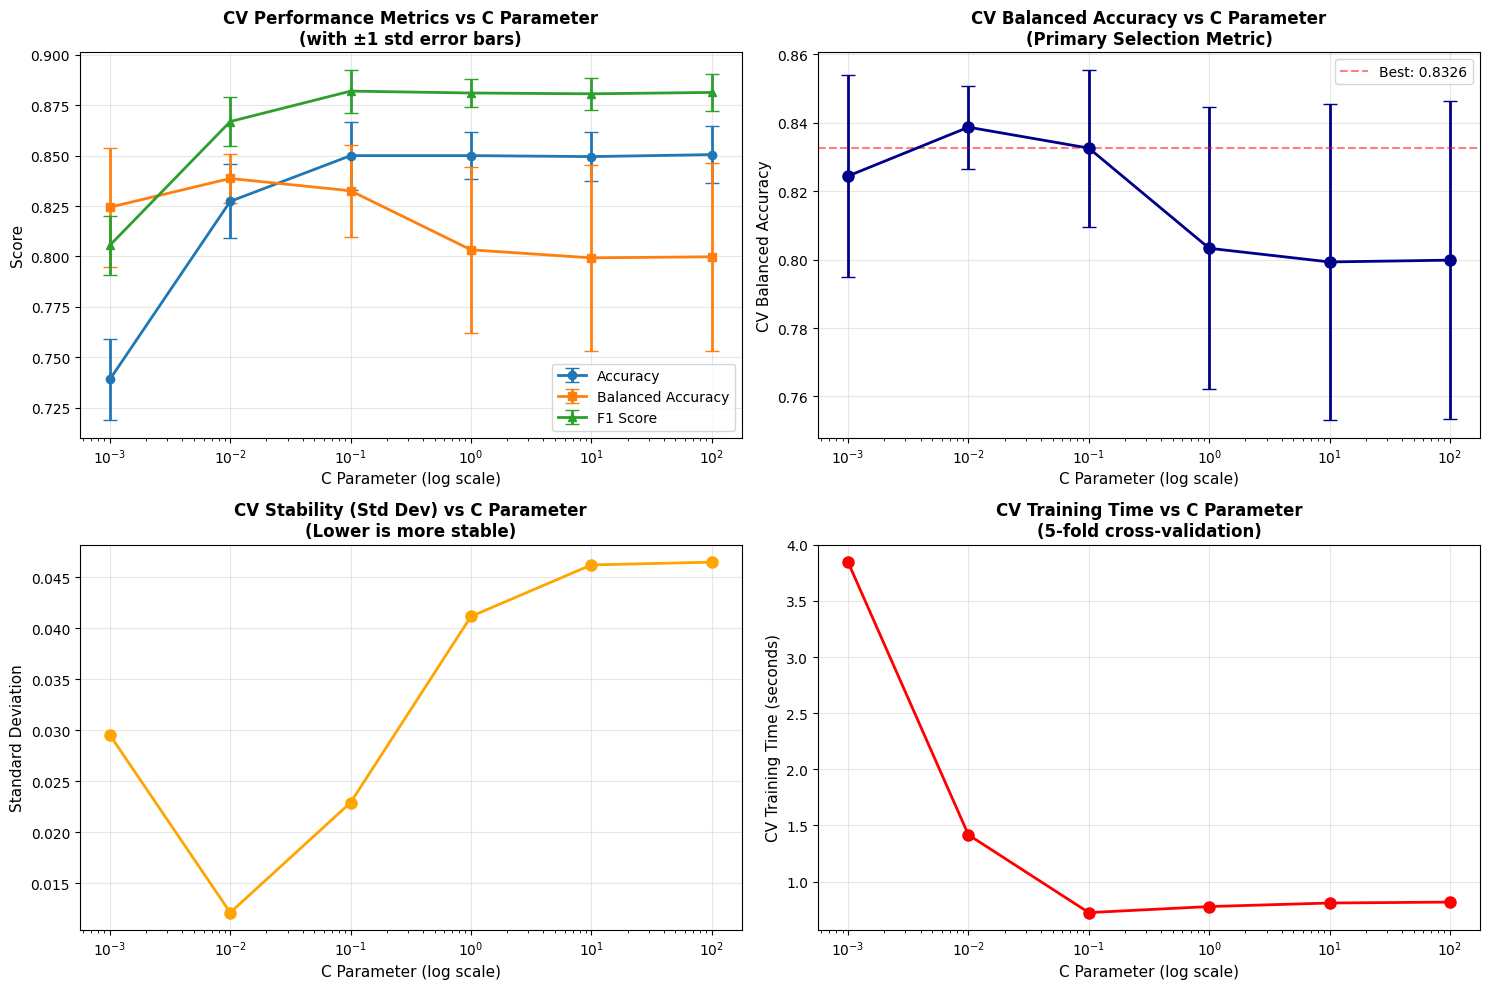

In [9]:
# Visualize C parameter impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics vs C (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(results_C_df['C'], results_C_df['cv_accuracy_mean'], 
             yerr=results_C_df['cv_accuracy_std'], 
             fmt='o-', label='Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='s-', label='Balanced Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_f1_mean'], 
             yerr=results_C_df['cv_f1_std'], 
             fmt='^-', label='F1 Score', linewidth=2, capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('CV Performance Metrics vs C Parameter\n(with ±1 std error bars)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Balanced Accuracy with tighter focus
ax2 = axes[0, 1]
ax2.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='o-', color='darkblue', linewidth=2, capsize=5, markersize=8)
ax2.axhline(y=best_bal_acc, color='red', linestyle='--', alpha=0.5, 
            label=f'Best: {best_bal_acc:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('C Parameter (log scale)', fontsize=11)
ax2.set_ylabel('CV Balanced Accuracy', fontsize=11)
ax2.set_title('CV Balanced Accuracy vs C Parameter\n(Primary Selection Metric)', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Standard deviation (uncertainty) vs C
ax3 = axes[1, 0]
ax3.plot(results_C_df['C'], results_C_df['cv_balanced_accuracy_std'], 
         'o-', color='orange', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('C Parameter (log scale)', fontsize=11)
ax3.set_ylabel('Standard Deviation', fontsize=11)
ax3.set_title('CV Stability (Std Dev) vs C Parameter\n(Lower is more stable)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: CV training time vs C
ax4 = axes[1, 1]
ax4.plot(results_C_df['C'], results_C_df['cv_time'], 
         'o-', color='red', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('C Parameter (log scale)', fontsize=11)
ax4.set_ylabel('CV Training Time (seconds)', fontsize=11)
ax4.set_title('CV Training Time vs C Parameter\n(5-fold cross-validation)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment - max_iter parameter

In [10]:
## 3. Experiment - max_iter Parameter (Convergence Analysis with CV)

print("="*60)
print("HYPERPARAMETER TUNING: MAX_ITER")
print("="*60)
print(f"Using best C value: {best_C}")
print("Testing max_iter values with 5-fold CV on training set...")
print("Using SCALED features\n")

max_iter_values = [500, 1000, 2000, 5000]
results_iter = []

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for max_iter in max_iter_values:
    print(f"\n  max_iter = {max_iter}")
    model = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    
    # Cross-validation on training set (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='f1_weighted',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    # Train once on full training set to check convergence (SCALED)
    model_check = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    model_check.fit(X_train_scaled, y_train)  # ← Using scaled data
    converged = model_check.n_iter_ < max_iter
    actual_iters = model_check.n_iter_
    
    results_iter.append({
        'max_iter': max_iter,
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'actual_iterations': actual_iters,
        'converged': converged,
        'cv_time': cv_time
    })
    
    print(f"    Converged: {converged} (used {actual_iters} iterations)")
    print(f"    CV F1 Score:          {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy: {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

results_iter_df = pd.DataFrame(results_iter)

print("\n" + "="*60)
print("CONVERGENCE ANALYSIS RESULTS")
print("="*60)
display(results_iter_df)

# Find best based on F1 score (primary metric)
best_iter_idx_f1 = results_iter_df['cv_f1_mean'].idxmax()
best_max_iter = results_iter_df.loc[best_iter_idx_f1, 'max_iter']

print(f"\nBest max_iter (based on F1 Score): {best_max_iter}")
print(f"CV F1 Score:          {results_iter_df.loc[best_iter_idx_f1, 'cv_f1_mean']:.4f}")
print(f"CV Balanced Accuracy: {results_iter_df.loc[best_iter_idx_f1, 'cv_balanced_accuracy_mean']:.4f}")
print(f"All models converged: {results_iter_df['converged'].all()}")

HYPERPARAMETER TUNING: MAX_ITER
Using best C value: 0.1
Testing max_iter values with 5-fold CV on training set...
Using SCALED features


  max_iter = 500
    Converged: True (used 7 iterations)
    CV F1 Score:          0.8820 ± 0.0106
    CV Balanced Accuracy: 0.8326 ± 0.0229
    CV time: 0.334s

  max_iter = 1000
    Converged: True (used 7 iterations)
    CV F1 Score:          0.8820 ± 0.0106
    CV Balanced Accuracy: 0.8326 ± 0.0229
    CV time: 0.307s

  max_iter = 2000
    Converged: True (used 7 iterations)
    CV F1 Score:          0.8820 ± 0.0106
    CV Balanced Accuracy: 0.8326 ± 0.0229
    CV time: 0.282s

  max_iter = 5000
    Converged: True (used 7 iterations)
    CV F1 Score:          0.8820 ± 0.0106
    CV Balanced Accuracy: 0.8326 ± 0.0229
    CV time: 0.291s

CONVERGENCE ANALYSIS RESULTS


,max_iter,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,actual_iterations,converged,cv_time
0,500,0.832589,0.022928,0.882031,0.010643,7,True,0.333868
1,1000,0.832589,0.022928,0.882031,0.010643,7,True,0.306740
2,2000,0.832589,0.022928,0.882031,0.010643,7,True,0.281810
3,5000,0.832589,0.022928,0.882031,0.010643,7,True,0.291136



Best max_iter (based on F1 Score): 500
CV F1 Score:          0.8820
CV Balanced Accuracy: 0.8326
All models converged: True


## Final Model Evaluation

FINAL MODEL EVALUATION ON TEST SET
Using best hyperparameters from CV:
  C = 0.1
  max_iter = 500
  Using SCALED features

Training final model on entire training set...
Training completed in 0.017s
Converged: True (used 7 iterations)

Evaluating on test set...

TEST SET PERFORMANCE (Unbiased Estimate)
  F1 Score (weighted):   0.8737  ← Primary Metric
  Balanced Accuracy:     0.8117
  Accuracy:              0.8383
  Precision (weighted):  0.9365
  Recall (weighted):     0.8383

CV TRAINING vs TEST SET COMPARISON
F1 Score:
  CV (training):  0.8820 ± 0.0106
  Test:           0.8737
  Difference:     0.0083

Balanced Accuracy:
  CV (training):  0.8326 ± 0.0229
  Test:           0.8117
  Difference:     0.0209

✓ Test F1 score is within CV std dev → Good generalization!

DETAILED CLASSIFICATION REPORT
                  precision    recall  f1-score   support

  Benign (False)       0.98      0.84      0.91       475
Malignant (True)       0.25      0.78      0.38        32

        accurac

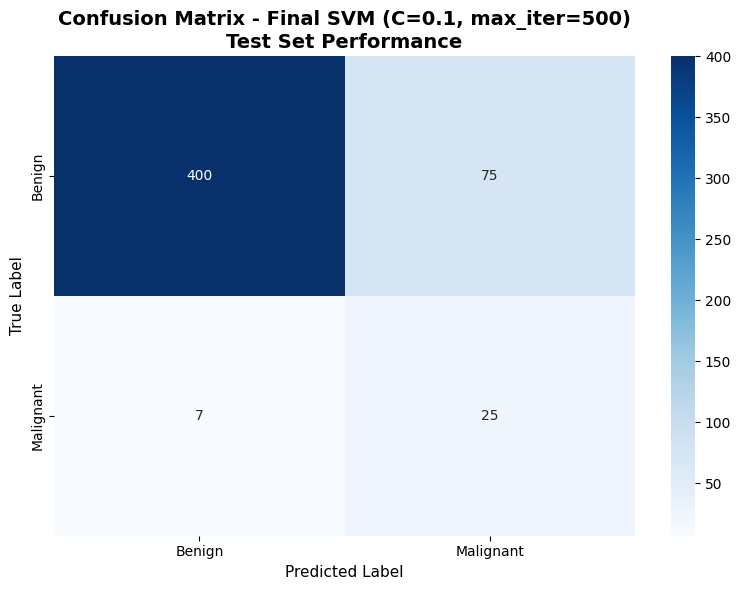


Confusion Matrix Breakdown:
  True Negatives (TN):  400 - Correctly identified benign
  False Positives (FP):  75 - Benign misclassified as malignant
  False Negatives (FN):   7 - Malignant misclassified as benign ⚠
  True Positives (TP):   25 - Correctly identified malignant

Additional Clinical Metrics:
  Specificity (True Negative Rate): 0.8421 - correctly identify benign
  Sensitivity (True Positive Rate): 0.7812 - correctly identify malignant
  False Negative Rate:              0.2188 ← Critical for cancer diagnosis
  False Positive Rate:              0.1579

MODEL SUMMARY
Final Model: LinearSVC
Hyperparameters: C=0.1, max_iter=500, class_weight='balanced'
Preprocessing: StandardScaler (zero mean, unit variance)
Test F1 Score: 0.8737
Test Balanced Accuracy: 0.8117
Convergence: 7 iterations


In [12]:
## 4. Final Model Evaluation on Test Set

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Using best hyperparameters from CV:")
print(f"  C = {best_C}")
print(f"  max_iter = {best_max_iter}")
print(f"  Using SCALED features")
print()

# Train final model with best hyperparameters on SCALED training data
final_model = LinearSVC(C=best_C, class_weight='balanced', max_iter=best_max_iter, random_state=42)

print("Training final model on entire training set...")
start = time.time()
final_model.fit(X_train_scaled, y_train)  # ← Using scaled data
final_train_time = time.time() - start

print(f"Training completed in {final_train_time:.3f}s")
print(f"Converged: {final_model.n_iter_ < best_max_iter} (used {final_model.n_iter_} iterations)")

# Predictions on test set (SCALED)
print("\nEvaluating on test set...")
y_pred_final = final_model.predict(X_test_scaled)  # ← Using scaled data

# Comprehensive metrics
test_acc = accuracy_score(y_test, y_pred_final)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_final)
test_f1 = f1_score(y_test, y_pred_final, average='weighted')
test_precision = precision_score(y_test, y_pred_final, average='weighted')
test_recall = recall_score(y_test, y_pred_final, average='weighted')

print("\n" + "="*60)
print("TEST SET PERFORMANCE (Unbiased Estimate)")
print("="*60)
print(f"  F1 Score (weighted):   {test_f1:.4f}  ← Primary Metric")
print(f"  Balanced Accuracy:     {test_bal_acc:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print(f"  Precision (weighted):  {test_precision:.4f}")
print(f"  Recall (weighted):     {test_recall:.4f}")

# Compare CV training performance vs test performance
print("\n" + "="*60)
print("CV TRAINING vs TEST SET COMPARISON")
print("="*60)
cv_best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
cv_best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
cv_best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
cv_best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"F1 Score:")
print(f"  CV (training):  {cv_best_f1:.4f} ± {cv_best_f1_std:.4f}")
print(f"  Test:           {test_f1:.4f}")
print(f"  Difference:     {abs(cv_best_f1 - test_f1):.4f}")

print(f"\nBalanced Accuracy:")
print(f"  CV (training):  {cv_best_bal_acc:.4f} ± {cv_best_bal_acc_std:.4f}")
print(f"  Test:           {test_bal_acc:.4f}")
print(f"  Difference:     {abs(cv_best_bal_acc - test_bal_acc):.4f}")

# Interpretation
if abs(cv_best_f1 - test_f1) < cv_best_f1_std:
    print("\n✓ Test F1 score is within CV std dev → Good generalization!")
else:
    print("\n⚠ Test F1 score differs from CV estimate → Check for overfitting/dataset shift")

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
# Get class names if available, otherwise use default labels
class_names = ['Benign (False)', 'Malignant (True)'] if len(y.unique()) == 2 else None
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'] if len(y.unique()) == 2 else None,
            yticklabels=['Benign', 'Malignant'] if len(y.unique()) == 2 else None)
plt.title(f'Confusion Matrix - Final SVM (C={best_C}, max_iter={best_max_iter})\nTest Set Performance', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[0,0]:3d} - Correctly identified benign")
print(f"  False Positives (FP): {cm[0,1]:3d} - Benign misclassified as malignant")
print(f"  False Negatives (FN): {cm[1,0]:3d} - Malignant misclassified as benign ⚠")
print(f"  True Positives (TP):  {cm[1,1]:3d} - Correctly identified malignant")

# Calculate per-class metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall for positive class

print(f"\nAdditional Clinical Metrics:")
print(f"  Specificity (True Negative Rate): {specificity:.4f} - correctly identify benign")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.4f} - correctly identify malignant")
print(f"  False Negative Rate:              {fn/(fn+tp):.4f} ← Critical for cancer diagnosis")
print(f"  False Positive Rate:              {fp/(fp+tn):.4f}")

print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Final Model: LinearSVC")
print(f"Hyperparameters: C={best_C}, max_iter={best_max_iter}, class_weight='balanced'")
print(f"Preprocessing: StandardScaler (zero mean, unit variance)")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"Convergence: {final_model.n_iter_} iterations")
print("="*60)